In [1]:
# Import of the data 
# This can take a while 

import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql import Window
import pandas as pd

DAU_SCHEMA = T.StructType([
    T.StructField('userId', T.StringType()),
    T.StructField('createdAt', T.StringType()),
    T.StructField(
        'data', T.StructType([
            T.StructField('activity-title', T.StringType()),
        ]),
    ),
])

PATH = "s3a://alpha-health-pro/red/evermind/events/2020/*/*/*/*"
evermindDF_raw = spark.read.schema(schema=DAU_SCHEMA).json(PATH)
evermindDF_raw.count()

/Users/yc00123/.virtualenvs/py3.6.8-data-access/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


686823

In [2]:
df = evermindDF_raw\
    .withColumn("date", F.date_format(F.to_timestamp(F.col("createdAt")), "yyyy-MM-dd"))\
    .toPandas()

In [3]:
df.dropna(subset = ['data'], inplace=True)

def get_data(x):
    return x[0]

df['activity'] = df['data'].apply(lambda x: get_data(x))

In [4]:
import datetime as dt
df['createdAt']= pd.to_datetime(df['createdAt'], utc=True) 
df['hour'] = df['createdAt'].dt.hour

In [5]:
df3 = df.groupby(['activity', 'userId'])
df3 = df3['date'].nunique().reset_index(name="count")

df3.sort_values(['count'], ascending = False)

,activity,userId,count
7519,Keeping a thought record,a03308ca-fbaf-4265-8257-b6ecf7ec4d40,24
9657,Positive thinking - people,98f3942d-c356-48c2-946e-02f91726e9b7,22
9123,Positive thinking - achievements,98f3942d-c356-48c2-946e-02f91726e9b7,22
16439,Waves,a7208087-c10f-4080-8b6a-e9738a530a54,21
9367,Positive thinking - gratitude,98f3942d-c356-48c2-946e-02f91726e9b7,21
...,...,...,...
6745,Keep stress in check while working from home,85011db6-f1c9-4e41-afd2-4ee09ef93258,1
6747,Keep stress in check while working from home,85fd5b61-3ad7-492f-b03c-2708d34a8e98,1
6748,Keep stress in check while working from home,86246e0f-960b-4eb1-96f0-51916a2f9396,1
6750,Keep stress in check while working from home,8792821f-7042-4f3f-99e6-a01de0c579d5,1


In [6]:
activities = df3.groupby('activity')
activities = activities['count'].mean().reset_index(name="mean_repetition")
activities.sort_values(['mean_repetition'], ascending = False)

,activity,mean_repetition
30,Keeping a thought record,3.110577
40,Positive thinking - gratitude,2.628931
84,Working on your bad habits,2.555556
39,Positive thinking - achievements,2.525000
45,Put your worries to bed,2.460317
...,...,...
56,Reviewing your bad sleep habits,1.142857
35,Moving forward,1.083333
37,Myths about sleep,1.074074
9,Challenging thoughts on sleep,1.000000


In [7]:
df_repetitions = df3[df3['count']>= 5]
df_repetitions.sort_values(['count'], ascending = False)

,activity,userId,count
7519,Keeping a thought record,a03308ca-fbaf-4265-8257-b6ecf7ec4d40,24
9657,Positive thinking - people,98f3942d-c356-48c2-946e-02f91726e9b7,22
9123,Positive thinking - achievements,98f3942d-c356-48c2-946e-02f91726e9b7,22
16439,Waves,a7208087-c10f-4080-8b6a-e9738a530a54,21
9367,Positive thinking - gratitude,98f3942d-c356-48c2-946e-02f91726e9b7,21
...,...,...,...
9771,Positive thinking - people,e3a037bf-4cee-4a31-b82d-20a82f732d3b,5
9767,Positive thinking - people,e062e190-23ce-4747-9665-a203abee57d0,5
9759,Positive thinking - people,dc9578be-0093-4526-8495-ea3550933fb1,5
9738,Positive thinking - people,cf3cc788-642c-4ef0-941f-1669252590aa,5


In [8]:
df_repetitions['userId'].nunique()

262

In [9]:
df_repetitions['activity'].nunique()

59

In [10]:
df_repetitions[df_repetitions['activity']=='Keeping a thought record']['userId'].nunique()

181

In [11]:
df_repetitions[df_repetitions['activity']=='Positive thinking - gratitude']['userId'].nunique()

23

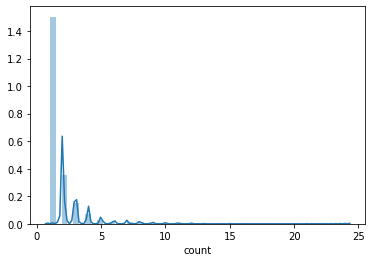

In [14]:
import seaborn as sns
sns.distplot(df3['count'])

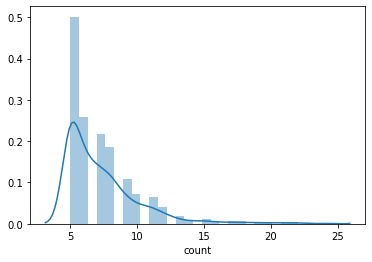

In [15]:
sns.distplot(df_repetitions['count'])

In [16]:
thoughts = df.copy()
thoughts = thoughts[thoughts['activity']=='Keeping a thought record']

In [17]:
import numpy as np
df4 = thoughts.groupby(['activity', 'userId'])['hour'].agg([np.mean, np.std]).reset_index()
df4.head()

,activity,userId,mean,std
0,Keeping a thought record,,12.865672,5.913907
1,Keeping a thought record,000d4f52-13dc-4600-9b02-3527dd646bc5,6.000000,0.000000
2,Keeping a thought record,0084bd82-3041-413d-ae1c-d7f39b2bdfe9,16.000000,0.000000
3,Keeping a thought record,01021dae-990a-4713-b087-a4208dde3f3d,15.500000,0.707107
4,Keeping a thought record,0115f360-76c2-4bf3-8874-bc214f699203,6.000000,0.000000


In [18]:
days = thoughts.groupby(['activity', 'userId'])
days = days['date'].nunique().reset_index(name='total_days')
days.set_index('userId')
days.head()

,activity,userId,total_days
0,Keeping a thought record,,7
1,Keeping a thought record,000d4f52-13dc-4600-9b02-3527dd646bc5,1
2,Keeping a thought record,0084bd82-3041-413d-ae1c-d7f39b2bdfe9,1
3,Keeping a thought record,01021dae-990a-4713-b087-a4208dde3f3d,2
4,Keeping a thought record,0115f360-76c2-4bf3-8874-bc214f699203,1


In [19]:
df4['total_days'] = days['total_days']
df4 = df4[df4['total_days']>= 5]
df4.sort_values(['total_days'], ascending = False)

,activity,userId,mean,std,total_days
506,Keeping a thought record,a03308ca-fbaf-4265-8257-b6ecf7ec4d40,13.949275,4.193012,24
796,Keeping a thought record,f5ff9aca-0969-432b-994f-e3ef1649ad04,15.785714,7.397845,20
360,Keeping a thought record,70414fb6-a9ce-4224-8609-9104243cf1a1,16.980100,1.699883,15
200,Keeping a thought record,3b674a79-3c21-4311-8de3-3c090a53e4ed,16.461538,6.280165,15
603,Keeping a thought record,bdc6fefe-565c-42fc-9252-a574a41399b7,9.696552,4.611767,14
...,...,...,...,...,...
172,Keeping a thought record,33ba9f67-40d9-441a-9b93-1a854f442509,9.875000,8.073977,5
292,Keeping a thought record,5a894ca9-9f72-40c7-b7ac-a431198b19bf,16.244444,2.356380,5
719,Keeping a thought record,dea81e98-e0c0-43cf-b818-cc2abe9a6c4e,15.625000,5.785131,5
228,Keeping a thought record,421af35d-408b-46d6-ba3a-dcce9de37fd3,13.382609,7.669240,5


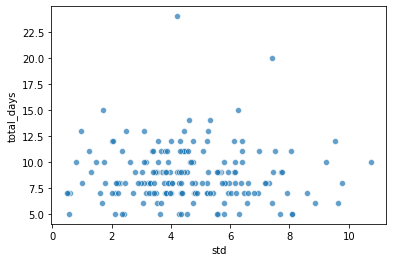

In [20]:
ax = sns.scatterplot(x="std", y="total_days", data=df4, alpha = 0.7)

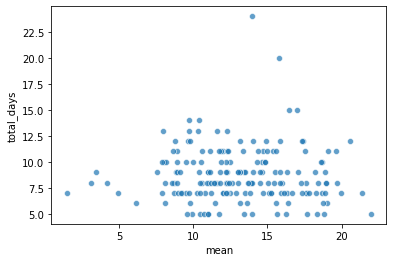

In [21]:
ax = sns.scatterplot(x="mean", y="total_days", data=df4, alpha = 0.7)